<a href="https://colab.research.google.com/github/RenataTNT/ML_in_Production/blob/master/ML_in_Biz_Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
Energy_data=pd.read_csv('my_PJME_MW.csv')

In [6]:
Energy_data

,Date,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
0,2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
1,2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2,2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
3,2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
4,2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145369,2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
145370,2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
145371,2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0
145372,2018-08-02,23:00:00,38500.0,2018,8,2,3,214,31,3,23,0,0,0


In [0]:
Energy_data.index=pd.to_datetime(Energy_data['Date'])

In [16]:
data_m=Energy_data.resample('M').mean()
data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


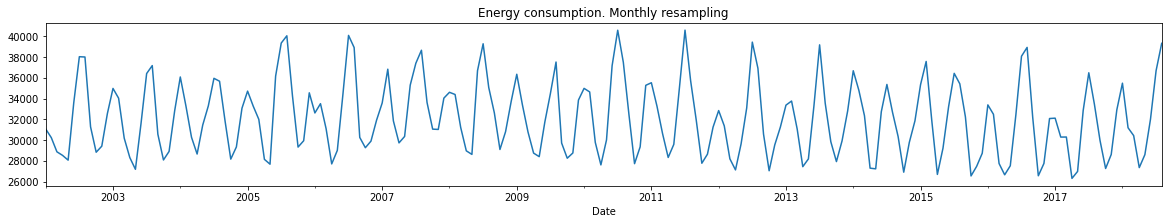

In [22]:
data_m['PJME_MW'].plot(figsize=(20,3), title='Energy consumption. Monthly resampling')

2. Подберите параметры модели SARIMAX для этого ряда.

In [24]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


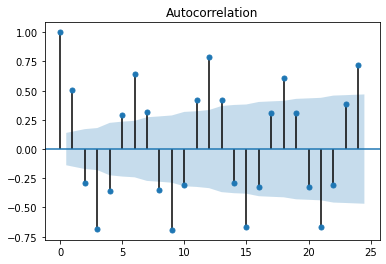

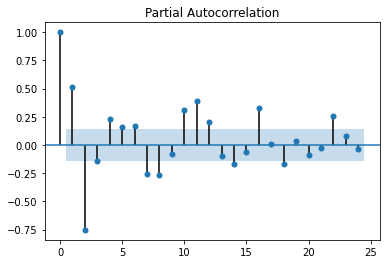

In [25]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24)
plt.show()

In [0]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [0]:
import warnings

In [0]:
warnings.filterwarnings("ignore") # отключает предупреждения
param_dict={}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values, order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            key=str(param)+'x'+str(param_seasonal)
        except:
            continue

In [0]:
import operator
param_sorted=sorted(param_dict.items(), key=operator.itemgetter(1))

In [43]:
#лучшие значения параметров
param_sorted[:5]

[('(1, 1, 2)x(0, 1, 2, 12)', 2827.599772056785),
 ('(2, 1, 2)x(0, 1, 2, 12)', 2827.9044450717283),
 ('(1, 1, 1)x(0, 1, 2, 12)', 2843.4037362872614),
 ('(1, 0, 2)x(0, 1, 2, 12)', 2844.136826641582),
 ('(0, 1, 2)x(0, 1, 2, 12)', 2845.0776485486113)]

In [63]:
#неидеальная модель
mod1 = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[1,0,1],
                                seasonal_order=[1,0,1,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_1 = mod1.fit()
print('AIC:{}',results_1.aic)

AIC:{} 3181.2597449793834


In [56]:
# модель по лучшим параметрам
mod2 = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[1,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod2.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2614.734791369401


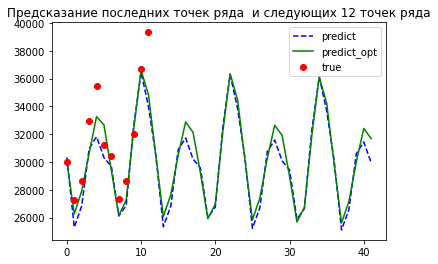

In [64]:
pred_dynamic = results_1.forecast(42)    #делаем предсказание на 42 точки от текущего конца ряда по неидеальной модели
pred_dynamic_opt = results_opt.forecast(42) #делаем предсказание на 42 точки от текущего конца ряда по лучшей модели

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [65]:
from sklearn.metrics import r2_score 
#качество предсказания неидельной модели
r2_score(data_m['PJME_MW'].values[-12:], pred_dynamic[0:12])

0.6320169603916169

In [66]:
#качество предсказания идельной модели
r2_score(data_m['PJME_MW'].values[-12:], pred_dynamic_opt[0:12])

0.7604062829381375

значение r2 у модели, построенной на лучших параметрах выше

3. Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

In [0]:
covid_data=pd.read_csv('covid_19_data_V66.csv')

In [0]:
COVID = covid_data.copy()

COVID['Date']= pd.to_datetime(COVID['ObservationDate']).dt.date


In [86]:
Russia=COVID.loc[COVID['Country/Region']=='Russia']
Russia_covid=France.set_index(pd.DatetimeIndex(France['Date'].values))
Russia_covid.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date
2020-04-10,13664,04/10/2020,NaN,Russia,2020-04-10 23:01:43,11917.0,94.0,795.0,2020-04-10
2020-04-11,13985,04/11/2020,NaN,Russia,2020-04-11 22:52:46,13584.0,106.0,1045.0,2020-04-11
2020-04-12,14306,04/12/2020,NaN,Russia,2020-04-12 23:25:00,15770.0,130.0,1291.0,2020-04-12
2020-04-13,14626,04/13/2020,NaN,Russia,2020-04-13 23:15:42,18328.0,148.0,1470.0,2020-04-13
2020-04-14,14946,04/14/2020,NaN,Russia,2020-04-14 23:41:11,21102.0,170.0,1694.0,2020-04-14


In [87]:
Russia_covid=Russia_covid.groupby('Date').sum()
Russia_covid=Russia_covid.drop('SNo', axis=1)
Russia_covid.tail()

,Confirmed,Deaths,Recovered
Date,,,
2020-04-10,11917.0,94.0,795.0
2020-04-11,13584.0,106.0,1045.0
2020-04-12,15770.0,130.0,1291.0
2020-04-13,18328.0,148.0,1470.0
2020-04-14,21102.0,170.0,1694.0


Будем анализировать не нарастающие итоги заболеваний, а дневные приросты

In [89]:
Russia_covid['Confirmed_daily']=Russia_covid['Confirmed']
Russia_covid['Confirmed_daily'].iloc[1:]=Russia_covid['Confirmed'].iloc[1:].values-Russia_covid['Confirmed'].iloc[:-1].values
Russia_covid

,Confirmed,Deaths,Recovered,Confirmed_daily
Date,,,,
2020-01-31,2.0,0.0,0.0,2.0
2020-02-01,2.0,0.0,0.0,0.0
2020-02-02,2.0,0.0,0.0,0.0
2020-02-03,2.0,0.0,0.0,0.0
2020-02-04,2.0,0.0,0.0,0.0
...,...,...,...,...
2020-04-10,11917.0,94.0,795.0,1786.0
2020-04-11,13584.0,106.0,1045.0,1667.0
2020-04-12,15770.0,130.0,1291.0,2186.0


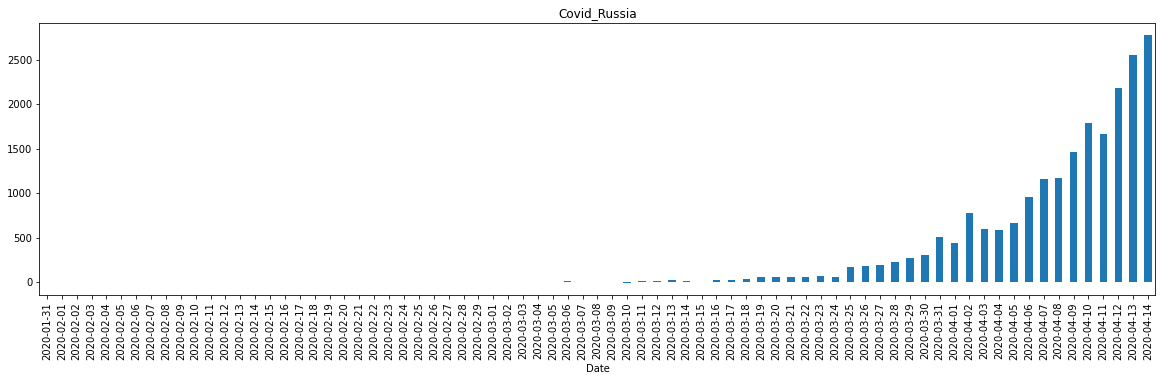

In [92]:
Russia_covid['Confirmed_daily'].plot(figsize=(20,5), title='Covid_Russia', kind='bar')

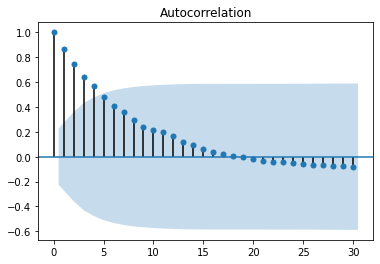

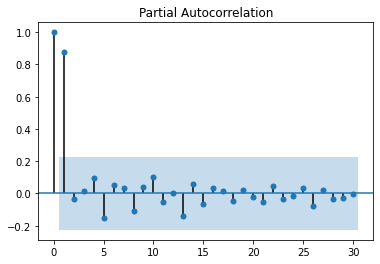

In [95]:
sm.graphics.tsa.plot_acf(Russia_covid['Confirmed_daily'].values, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(Russia_covid['Confirmed_daily'].values, lags=30)
plt.show()

Дневные графики показывают снижение автокорреляции изо дня в день, сезонности нет, и для на PACF мы видим, что только 1-й порядок разностей важен для нашего процесса (AR 1). Запустим SARIMA без сезонности

In [130]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(Russia_covid['Confirmed_daily'].values[:-5],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results_cov = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, results_cov.aic))

print(results_cov.summary().tables[0],results_cov.summary().tables[1])

ARIMA[1, 1, 1] - AIC:763.2990217109713
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -376.650
Date:                Thu, 16 Apr 2020   AIC                            763.299
Time:                        17:44:49   BIC                            774.322
Sample:                             0   HQIC                           767.661
                                 - 70                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    

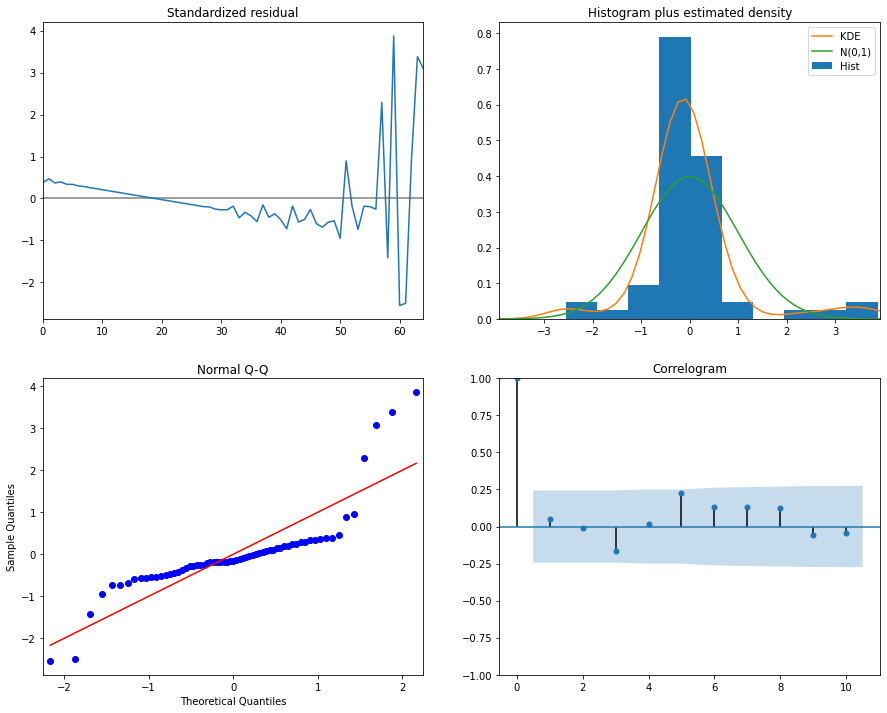

In [124]:
results_cov.plot_diagnostics(figsize=(15, 12))
plt.show()

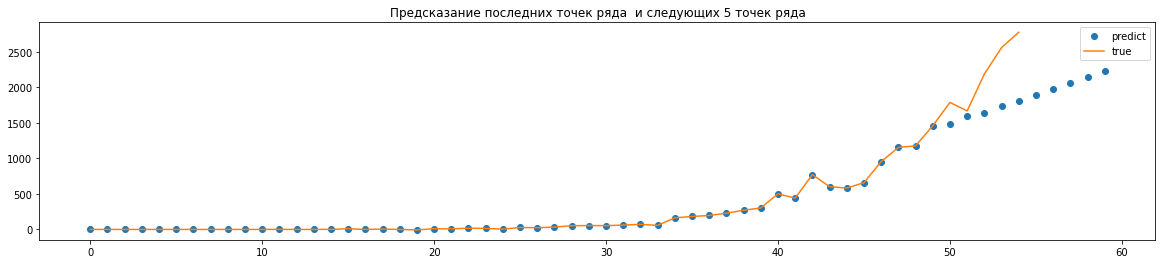

In [131]:
import numpy as np

plt.figure(figsize=(20,4))

pred_dynamic = results_cov.forecast(10)    #делаем предсказание на 10 точки от текущего конца ряда

plt.plot(list(Russia_covid['Confirmed_daily'].values[20:-5])+list(pred_dynamic),'o', label='predict')
#Отобразим истинный значения 
plt.plot(Russia_covid['Confirmed_daily'].values[20:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [126]:
Russia_covid['Confirmed_daily'].values[-7:]

array([1175., 1459., 1786., 1667., 2186., 2558., 2774.])

In [127]:
pred_dynamic

array([1230.81212364, 1282.68711936, 1357.63656003, 1415.98446949,
       1490.51842354, 1554.14330743, 1629.25007948, 1697.33521907,
       1773.68973208, 1845.67738212])

"В Лоб" все очень плохо. Возьмем диапаон данных когда стал наблюдаться увеличивающийся рост и применим boxcox преобразование

In [137]:
Russia_covid.describe()

,Confirmed,Deaths,Recovered,Confirmed_daily
count,75.000000,75.000000,75.000000,75.000000
mean,1949.493333,14.960000,139.626667,281.360000
std,4427.248796,35.508826,341.506708,607.491289
min,2.000000,0.000000,0.000000,-7.000000
25%,2.000000,0.000000,2.000000,0.000000
50%,13.000000,0.000000,3.000000,2.000000
75%,938.000000,3.500000,41.500000,189.000000
max,21102.000000,170.000000,1694.000000,2774.000000


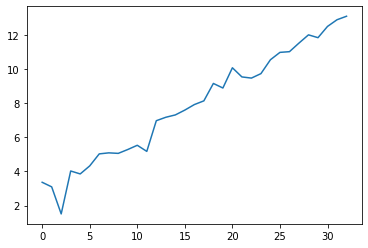

In [148]:
import scipy.stats as scs

X_dif_log, lmbda_dif = scs.boxcox(Russia_covid['Confirmed_daily'].values[42:])
plt.plot(X_dif_log)
plt.show()

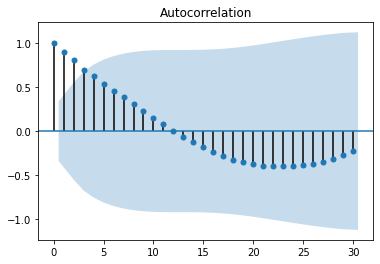

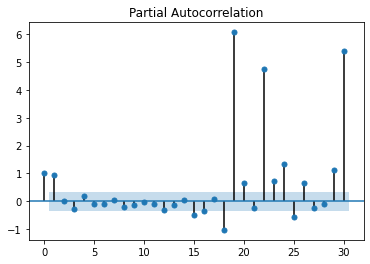

In [149]:
sm.graphics.tsa.plot_acf(X_dif_log, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(X_dif_log, lags=30)
plt.show()

In [150]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(X_dif_log[:-5],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results_cov_log = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, results_cov_log.aic))

print(results_cov.summary().tables[0],results_cov_log.summary().tables[1])

ARIMA[1, 1, 1] - AIC:38.976549064992724
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -376.650
Date:                Thu, 16 Apr 2020   AIC                            763.299
Time:                        18:00:01   BIC                            774.322
Sample:                             0   HQIC                           767.661
                                 - 70                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   

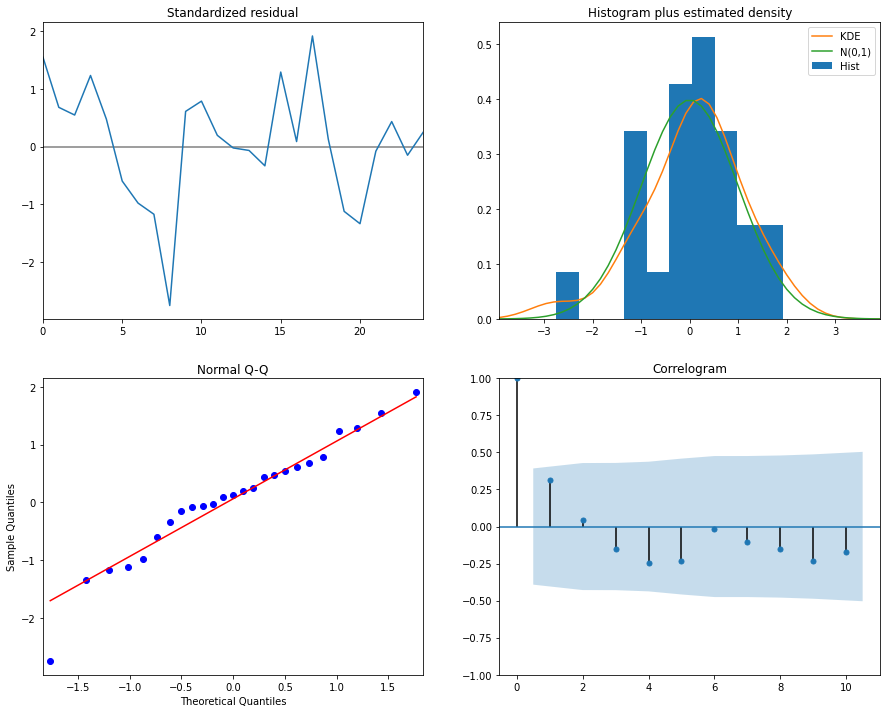

In [151]:
results_cov_log.plot_diagnostics(figsize=(15, 12))
plt.show()

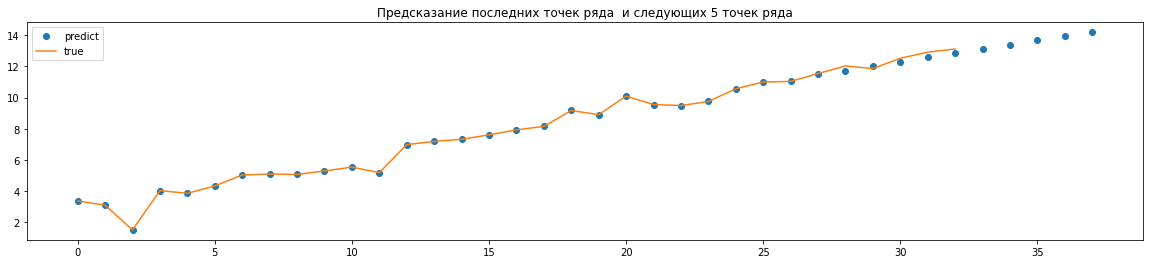

In [152]:

plt.figure(figsize=(20,4))

pred_dynamic_log = results_cov_log.forecast(10)    #делаем предсказание на 10 точки от текущего конца ряда

plt.plot(list(X_dif_log[:-5])+list(pred_dynamic_log),'o', label='predict')
#Отобразим истинный значения 
plt.plot(X_dif_log,label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [0]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Обратное предобазование

In [157]:
pred_log_inv=invboxcox(pred_dynamic_log,lmbda_dif)
pred_log_inv

array([1557.98326791, 1774.01811635, 1991.79037724, 2233.54820748,
       2496.66032774, 2783.05705146, 3093.84213762, 3430.26680635,
       3793.54604082, 4184.88476491])

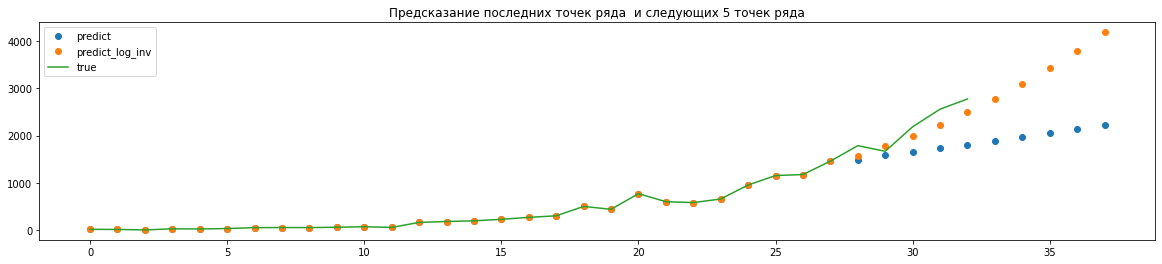

In [159]:
plt.figure(figsize=(20,4))

plt.plot(list(Russia_covid['Confirmed_daily'].values[42:-5])+list(pred_dynamic),'o', label='predict')
plt.plot(list(Russia_covid['Confirmed_daily'].values[42:-5])+list(pred_log_inv),'o', label='predict_log_inv')
#Отобразим истинный значения 
plt.plot(Russia_covid['Confirmed_daily'].values[42:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [164]:
r2_score(Russia_covid['Confirmed_daily'].values[-5:],pred_dynamic[:5])

-1.198596752874106

In [165]:
r2_score(Russia_covid['Confirmed_daily'].values[-5:],pred_log_inv[:5])


0.6897034708858019

Качество стало более-менее приемлемое

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA

Техника ARIMA, на мой взгляд лучше, работает с моделями типа стационарный ряд + сезонность или адитивный тренд. Иные мультипликативные модели требуют дополнительного преобразования данных, убирающих мультитпликативность тренда